# Laplacian Viscosity

Plot the Laplacian viscosity. This viscosity is zero in the non-backscatter simulations and negative in the backscatter simulations.

In [1]:
import os
import sys
sys.path.insert(1,'/glade/u/home/yhoussam/analysis/mom6_diagnostics')
from analysis_mom6 import *
import matplotlib.pyplot as plt
import cmocean
from cartopy import crs as ccrs
from tqdm import tqdm
import colorcet as cc

data_path = '/glade/u/home/yhoussam/analysis/simulations/data/'
def return_ncfile_path(analysis_dir,sim,file):
    nc_dir = os.path.join(analysis_dir,sim)
    nc_dir = os.path.join(nc_dir,'ncfiles')
    file_name = sim+'_'+file+'.nc'
    path =  os.path.join(nc_dir,file_name)
    return path


import warnings
from xarray.coding.times import SerializationWarning

warnings.filterwarnings(
    "ignore",
    "Unable to decode time axis into full numpy.datetime64 objects",
    category=SerializationWarning
)


save_path = 'png/'
import matplotlib as mpl
mpl.rcParams['font.size'] = 20
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

### Load simulations

In [2]:
case_names = ['gmom.e23.GJRAv3.TL319_t025_hycom1_N75.tx1_4.smag_control.003',
              'gmom.e23.GJRAv3.TL319_t025_hycom1_N75.tx1_4.MEKE_GM.004',
              'gmom.e23.GJRAv3.TL319_t025_hycom1_N75.tx1_4.MEKE_GM.007',
              'gmom.e23.GJRAv3.TL319_t025_hycom1_N75.tx1_4.leith_GM.028'
              ]
snames = ['REF','GM','GM+MBK','GM+LBK']
c= ['xkcd:black','xkcd:grey','xkcd:dark red','xkcd:dark orange'] 


loc = 'archive'

sims = []
for i in range(len(snames)):
    sim = MOM6_simulation(snames[i],case_names[i],loc=loc)
    sims.append(sim)

num_sims = len(sims)

start_date = '0031-01-01'
end_date = '0061-12-31'
start_year = int(start_date[:4])
end_year = int(end_date[:4])

alpha_res = 2.
p_res = 50
def resolution(R,alpha,p):
    return 1./(1+(alpha*R)**p)


In [3]:
from ncar_jobqueue import NCARCluster
from dask.distributed import Client
nw = 6

parallel = False
if nw > 1:
    parallel = True
    cluster = NCARCluster(interface='ext',project='P93300012')
    cluster.scale(nw)
    client = Client(cluster)

client

/glade/work/yhoussam/conda-envs/mom6_solutions/lib/python3.8/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/work/yhoussam/conda-envs/mom6_solutions/lib/python3.8/site-packages/dask_jobqueue/core.py:274: FutureWarning: env_extra has been renamed to job_script_prologue. You are still using it (even if only set to []; please also check config files). If you did not set job_script_prologue yet, env_extra will be respected for now, but it will be removed in a future release. If you already set job_script_prologue, env_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/yhoussam/proxy/38311/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/yhoussam/proxy/38311/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.174:33227,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/yhoussam/proxy/38311/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [4]:
%%time

res_funcs = []
lap_viscs = []
bi_viscs = []

for i in range(num_sims):
    sim = sims[i]
    sim.open_files_by_year(sim.ocn_data_path, sim.native_end, start_year, end_year)
    sim.open_grid()
    sim.ds = sim.ds.chunk({'time': 12})
    sim.ds = sim.ds.sel(time=slice(start_date,end_date))
    
    Rd_dx = sim.ds.Rd_dx.mean('time').compute()    
    res_func = resolution(Rd_dx,alpha_res,p_res)
    res_funcs.append(res_func)

    depth=0
    index = (np.abs(sim.ds.zl - depth)).argmin().item()
    depth = sim.ds.zl[index].item()
    lap_visc = sim.ds.difmxylo.isel(zl=index).mean('time').compute()  
    lap_viscs.append(lap_visc)

    #depth=0
    #index = (np.abs(sim.ds.zl - depth)).argmin().item()
    #depth = sim.ds.zl[index].item()
    #bi_visc = sim.ds.difmxybo.isel(zl=index).mean('time').compute()  
    #bi_viscs.append(bi_visc)



Opened 372 files (0031-0061, match='h.native')
Opened grid and assigned coordinates.
Opened 372 files (0031-0061, match='h.native')
Opened grid and assigned coordinates.
Opened 372 files (0031-0061, match='h.native')
Opened grid and assigned coordinates.
Opened 372 files (0031-0061, match='h.native')
Opened grid and assigned coordinates.
CPU times: user 1min 35s, sys: 7.87 s, total: 1min 43s
Wall time: 7min 53s


### Plot negative of Laplacian viscosity

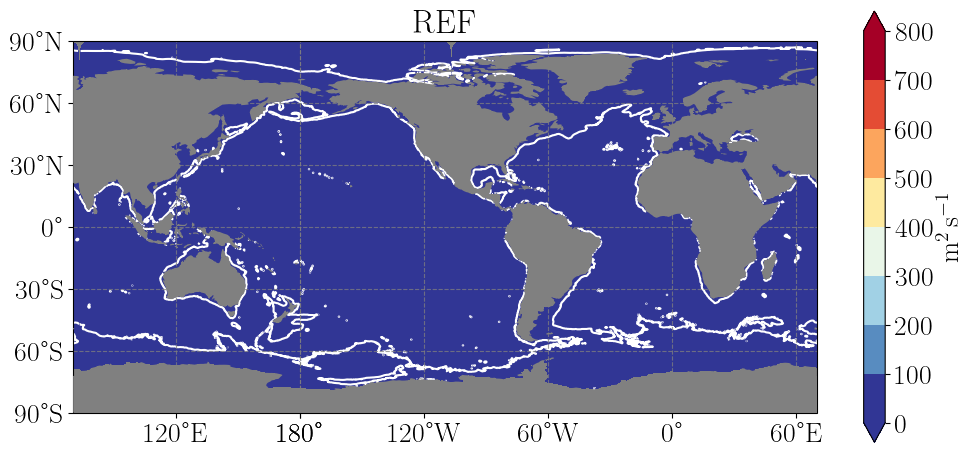

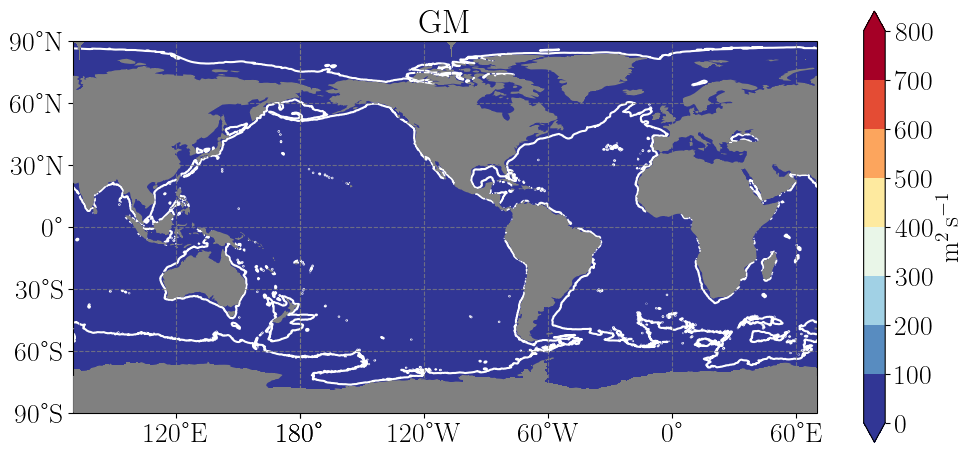

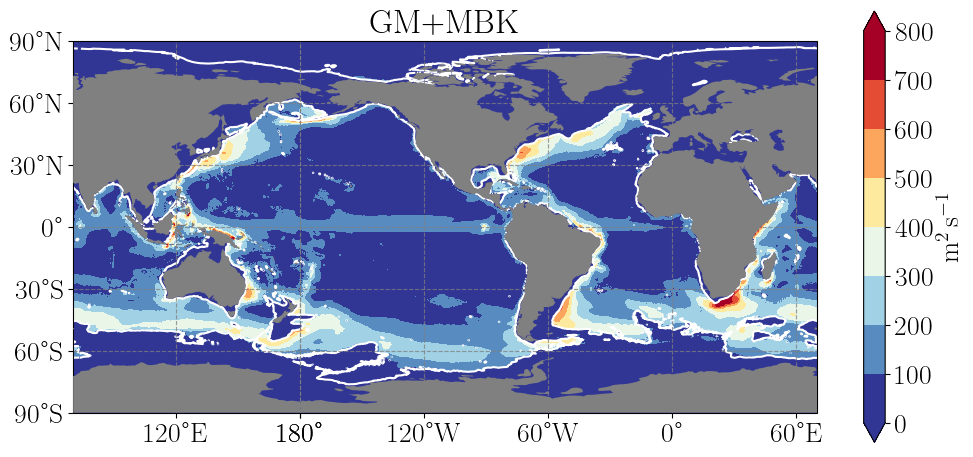

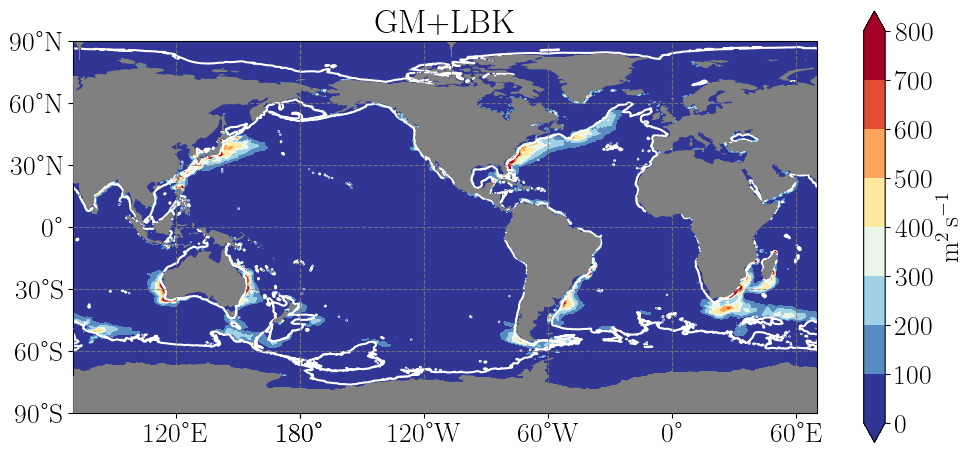

In [5]:
import matplotlib.colors as mcolors
import cartopy
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
cmap = cm.RdYlBu_r
vmin, vmax = 0, 800
n_steps = 8  # how many discrete bands you want
levels = np.linspace(vmin, vmax, n_steps + 1)   # e.g. [0.0,0.25,0.5,…,2.0]

# create a BoundaryNorm so each interval maps to one color
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cm.RdYlBu.N, clip=True)

for sim, R, lap_visc in zip(sims, res_funcs, lap_viscs):
    title = sim.short_name
    # pass norm instead of vmin/vmax
    ref_mask = lap_viscs[0].notnull()
    lap_visc = lap_visc.where(ref_mask)
    mappable = sim.plot_global_discrete(-lap_visc,
                                        cmap=cmap,
                                        levels=levels,
                                        cbar_label= r'$\mathrm{m^2\,s^{-1}}$',
                                        title=title,
                                        figsize=(12,8),
                                        R=R,
                                        R_threshold=0.5,
                                        contour_color='w', 
                                        contour_linewidth=1.5, 
                                        contour_linestyle='-')
    
    ax = plt.gca()
    ax.add_feature(cartopy.feature.LAND, facecolor='gray',zorder=10) 
    # set up graticules
    lon_ticks = np.arange(-180, 181, 60)
    lat_ticks = np.arange(-90, 91, 30)
    ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.gridlines(draw_labels=False, linestyle='--', color='gray', alpha=0.5)
    plt.savefig(save_path+title+'_laplacian_visc.png',dpi=300)